In [157]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy


In [158]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'installment_rate', 'personal_status', 'debtors', 'residencesince', 'property', 'age', 'install_plans', 'housing', 'existing_credits', 'job', 'maintenance_paying_people', 'telephone', 'foreign_worker', 'result']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
df = pd.read_csv(url, delimiter=' ', names=cols, index_col=False)
df['result'] = df['result'].replace(2,0)

In [159]:
df.head()

,status,duration,credit_hist,purpose,credit_amt,savings,employment,installment_rate,personal_status,debtors,...,property,age,install_plans,housing,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [160]:
def preprocess_german(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)
    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    pd.get_dummies(df, columns=['purpose', 'housing'], drop_first=True)

    return df

In [161]:
df = preprocess_german(df)

In [162]:
df = df.drop(["purpose", "housing", "personal_status"], axis=1)
x = df[['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'installment_rate', 'debtors', 'residencesince',
       'property', 'age', 'install_plans', 'existing_credits', 'job',
       'maintenance_paying_people', 'telephone', 'foreign_worker',
       'gender']]

y = df['result']

In [163]:
len(y)

1000

In [164]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=15)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [165]:
x_test_orig = copy.deepcopy(x_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test_scalar = sc.fit_transform(x_test)
print(type(x_test_scalar))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [166]:
#calculate the influence of each train data point by retraining


In [168]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)
    logistic_model = LogisticRegression(input_size=x_train_temp.shape[1], epoch_num=800)
    logistic_model.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = logistic_model.predict_proba(x_test_scalar_temp)
    # print(y_pred_proba_temp.shape)
    # print(y_pred_proba_temp[0:10])

    privileged_gp_indices = x_test_temp[x_test_temp['age'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['age'] == 0].index
    # y_pred_proba returns an array, how do we know whether that is for the positive label or negative label.
    # assuming it gives us the probability of the positive class

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    # privileged_positive_pred = y_pred_proba[privileged_gp_indices, 1][y_pred_proba[privileged_gp_indices, 1] > 0.5].mean()
    # protected_positive_pred = y_pred_proba[protected_gp_indices, 1][y_pred_proba[protected_gp_indices, 1] > 0.5].mean()
    # print(protected_positive_pred - privileged_positive_pred)

    return  protected_positive_pred - privileged_positive_pred

In [169]:
import pickle 

data = {'Xtrain': x_train, 'Ytrain': y_train, 'Xtest': x_test}
with open('data.pkl', 'wb') as f:
    pickle.dump(data,f)

In [170]:
dp_ori = demographic_parity(x_train, y_train, x_test)
print(dp_ori)


-0.0023736701267659255


In [171]:
# find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# results are calculated and stored in a file, hence commented to save the train time for 800 iterations 

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

result = []

for i in range(len(x_train)):
    x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, x_test)
    print(res)
    result.append(res)

# print(result)


0.0007224701359490604
1.1302220929931828e-05
0.0005765120662830636
-0.00024613427740172167
-0.0001010529169251928
0.0023062512559346438
-0.00036335469763948414
-0.0002921885188095219
0.0004726392086873421
-1.0013575481027104e-05
-0.00031434580480382834
0.00015304442386177008
-0.0004004580564821447
0.0020644450057939467
-0.002788526481083964
-0.0005117207184636152
9.169698226296763e-05
-0.000652683045547997
0.0006749326529016386
0.0003207441688048984
0.0010872358157311135
-0.00011784177639018178
-0.0006571673365132202
-0.00021027283206864755
8.224313467486422e-05
0.0004283349677832726
-0.0004944064599341491
0.0006049117188394737
4.054909503026227e-05
-0.0031877074577034703
0.0021966051956598953
0.0006187903350478585
-8.519934012263253e-05
-0.00022372118329916368
-0.0005820958915664365
0.00020189567809758557
-0.0003015436304707464
-0.0005315122490505697
-0.00028994000233018014
0.0005483762001046166
-0.00018483203792818426
0.0009787556381873896
-0.0006146260220714073
-0.002405795418185974

In [172]:
# np.save('trained_dp.npy', result)

In [173]:
clf = eval('LogisticRegression')(input_size=x_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [174]:
del_F_del_theta = del_spd_del_theta(clf, x_test_orig, x_test_scalar, y_test)
print(del_F_del_theta.shape)
print(type(del_F_del_theta))

(19,)
<class 'numpy.ndarray'>


In [175]:
hessian_all_points = get_hessian_all_points(clf, x_train, y_train, loss_func)


100%|██████████| 800/800 [00:04<00:00, 194.12it/s]


In [176]:
print(hessian_all_points.shape)

(800, 19, 19)


In [177]:
del_L_del_theta = get_del_L_del_theta(clf, x_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(800, 19)


In [178]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 


In [179]:
print(hinv_v.shape)

(19,)


df/d_epsi = df/d_theta * d_theta/d_epsi

d_theta/d_epsi = (1/n)* -H_inv * dL/d_theta 

df/d_theta = del_F_del_theta

In [180]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))  #it should be hessian* dL/d_theta 
# and then it should be multiplied by df/d_theta

In [181]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
inf = inf * 0.00125
print(inf.shape)

(800,)


In [182]:
print(type(inf))

print(np.min(inf))
print(np.max(inf))


<class 'numpy.ndarray'>
-0.0034379298344693106
0.004556593355610301


In [183]:
print(inf)

[ 8.25059774e-04  3.58278578e-05  4.44042929e-04 -2.72430957e-04
 -1.76257456e-04  3.06041474e-03 -7.83823011e-04 -4.82712351e-04
  6.53703149e-04  6.87775873e-05 -2.01011294e-04  2.35458412e-04
 -1.20844927e-03  3.23781215e-03 -9.93206237e-04 -5.52126182e-04
  1.79369993e-04 -9.30188725e-04  1.09466950e-03  4.90998151e-04
  6.41701556e-04 -4.30535838e-04 -1.09459891e-03 -1.89667275e-03
  1.32980084e-04  5.76217351e-04 -8.12543526e-04  4.14401415e-04
 -3.60099439e-05 -3.42638023e-03  4.35805753e-03  2.74469448e-03
 -1.90192148e-04 -5.19210998e-04 -1.15517459e-03  4.27898471e-04
 -1.11378305e-03 -7.57348881e-04 -9.96016491e-04  4.21015240e-04
 -4.90273407e-04  1.03591281e-03 -8.29551855e-04 -2.72371687e-03
  3.98524692e-04  4.71261896e-04 -4.73871512e-04 -1.31517652e-03
 -1.13277206e-03  7.52816832e-05 -1.15666934e-03 -9.27452914e-04
  6.06210287e-04  2.39435957e-04  3.66509635e-03  3.09571123e-03
 -1.35735845e-03 -1.14901244e-03  1.70543110e-03  2.81286646e-03
  3.69696805e-03 -1.17788

In [184]:
# result = np.load('trained_dp.npy')
# trained_arr = np.array(result)

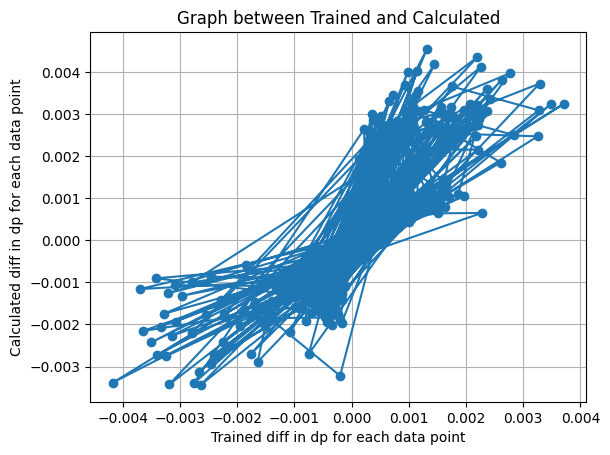

In [185]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'Trained': result, 'Calculated': inf})
plt.plot(df['Trained'], df['Calculated'], marker='o', linestyle='-')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained diff in dp for each data point')
plt.ylabel('Calculated diff in dp for each data point')
plt.grid(True)
plt.show()